### Audio Recognition for Speech Commands dataset

#### 1.1 Importing the Speech Commands dataset

In [ ]:
import os
import pathlib
import tensorflow as tf

DATASET_PATH = 'data/mini_speech_commands'
data_dir = pathlib.Path(DATASET_PATH)

#Extracting mini_speech_commands dataset if it is unavailable

if not data_dir.exists() :
  tf.keras.utils.get_file(
    fname='mini_speech_commands.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip',
    extract=True,
    cache_dir='.',
    cache_subdir='data'
  )



182082353/182082353 [==============================] - 1s 0us/step


In [ ]:
#Getting the different commands in the dataset
commands = [x for x in os.listdir(DATASET_PATH) if x != 'README.md']
print(f"Commands : {commands}")

Commands : ['left', 'go', 'no', 'stop', 'up', 'down', 'right', 'yes']


In [ ]:
import numpy as np

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset="both"
)

labels = np.array(train_ds.class_names)
print('----------------------------------------------')
print(f'Labels : {labels}')

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.
----------------------------------------------
Labels : ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


### 1.2 Preprocess the data

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
# Squeezing the extra dimension of channels as there is only one

def squeeze(audio, labels) :
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [ ]:
#Splitting the validation set into validation and test sets

test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [ ]:
for sample_audio, sample_labels in train_ds.take(1) :
  print(f"Audio Shape : {sample_audio.shape}")
  print(f"Label Shape : {sample_labels.shape}")

Audio Shape : (64, 16000)
Label Shape : (64,)


### 1.3 Plotting the audio waveforms

In [ ]:
labels[[1, 0, 3, 1]]

array(['go', 'down', 'no', 'go'], dtype='<U5')

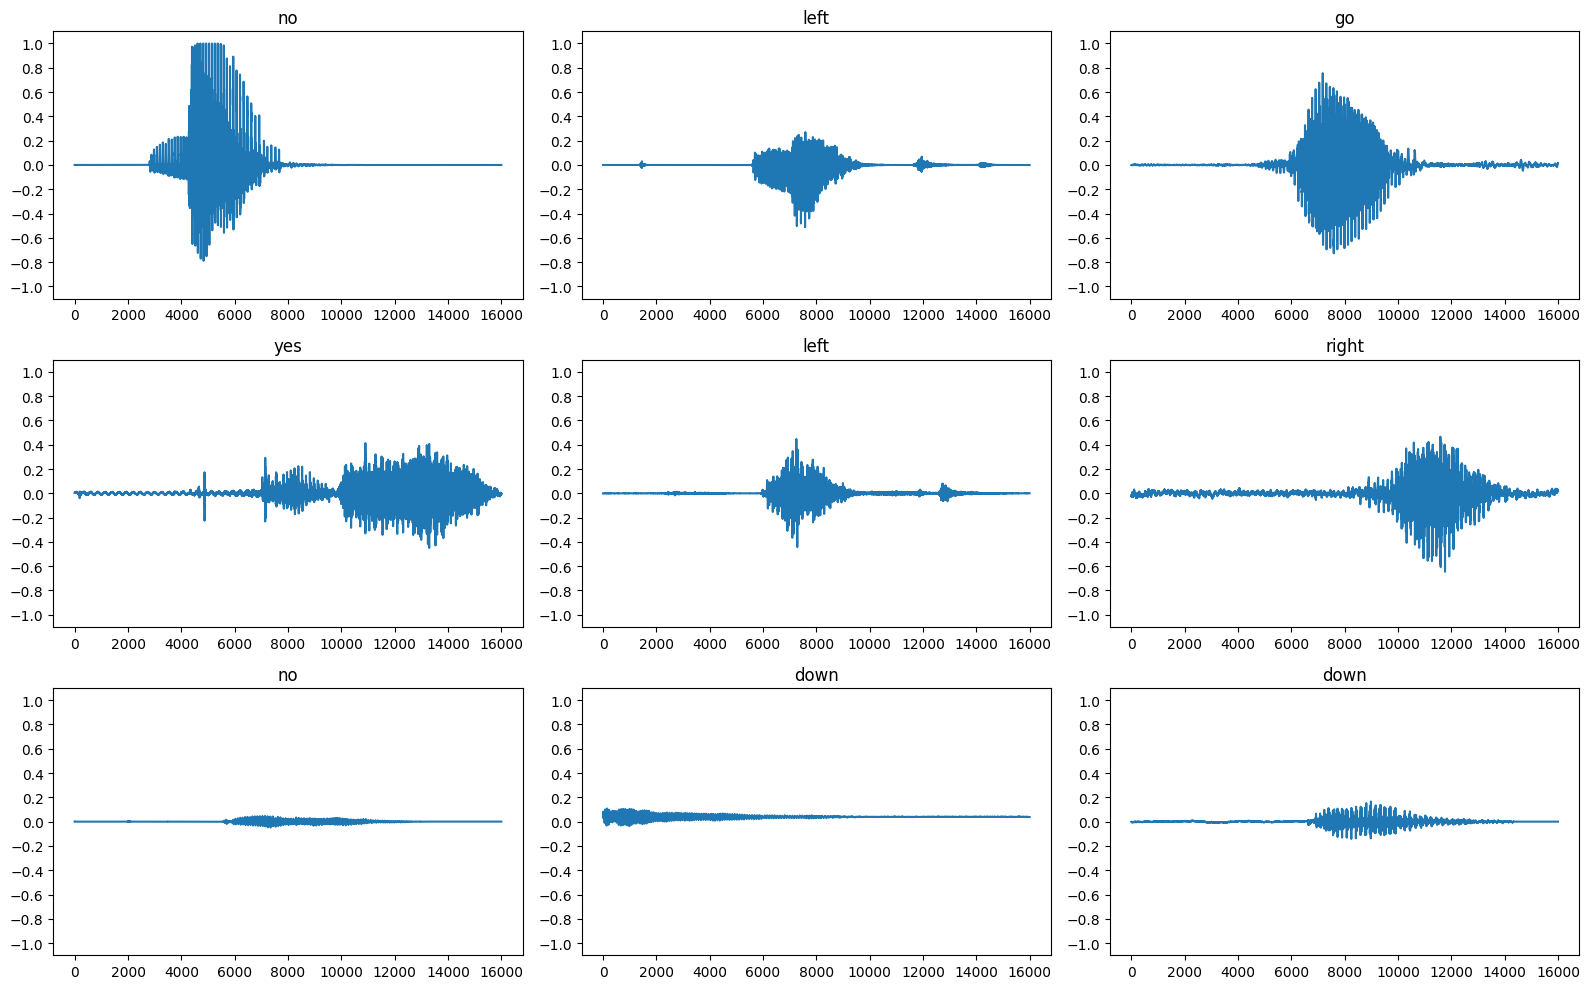

In [ ]:
#Creating a plot with 9 audio samples and corresponding labels
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))

rows = 3
cols = 3

for i in range(1, rows * cols + 1) :
  plt.subplot(rows, cols, i)
  audio_sample = sample_audio[i]
  audio_label = labels[sample_labels[i]]
  plt.plot(audio_sample)
  plt.title(audio_label)
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])
  plt.tight_layout()

### 1.4 Converting the audio data waveforms into spectrograms

In [ ]:
def get_spectrogram(waveform) :
  # 1. Waveform to Spectrogram using Short-time Fourier Transform
  spectrogram = tf.signal.stft(waveform,
                              frame_length=255,
                              frame_step=128)

  # 2. Getting the magnitude of Spectrogram
  spectrogram = tf.abs(spectrogram)

  # 3. Adding a new axis to make it look like (batch, samples, channels) form of an image
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:

from IPython import display

for i in range(3) :
  label = sample_labels[i]
  waveform = sample_audio[i]
  spectrogram = get_spectrogram(waveform)

  print(f"Label            : {labels[label]}")
  print(f"Waveform Shape   : {waveform.shape}")
  print(f"Spectrogram Shape : {spectrogram.shape}")
  display.display(display.Audio(waveform, rate=16000))

Label            : go
Waveform Shape   : (16000,)
Spectrogram Shape : (124, 129, 1)


Label            : no
Waveform Shape   : (16000,)
Spectrogram Shape : (124, 129, 1)


Label            : left
Waveform Shape   : (16000,)
Spectrogram Shape : (124, 129, 1)


In [ ]:
# Plotting the spectrogram

def plot_spectrogram(spectrogram, ax) :

  # 1. Check if length of spectrogram.shape == 3 else raise an AssertionError and squezze the extra dim
  if(len(spectrogram.shape) > 2) :
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)

  # 2. Do a logarithmic transformation on the spectrogram and add a epsilon to avoid taking log(0)
  log_spec = np.log(spectrogram + np.finfo(float).eps)
  height, width = log_spec.shape[0], log_spec.shape[1]

  # 3. Set X and Y for the colormesh
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

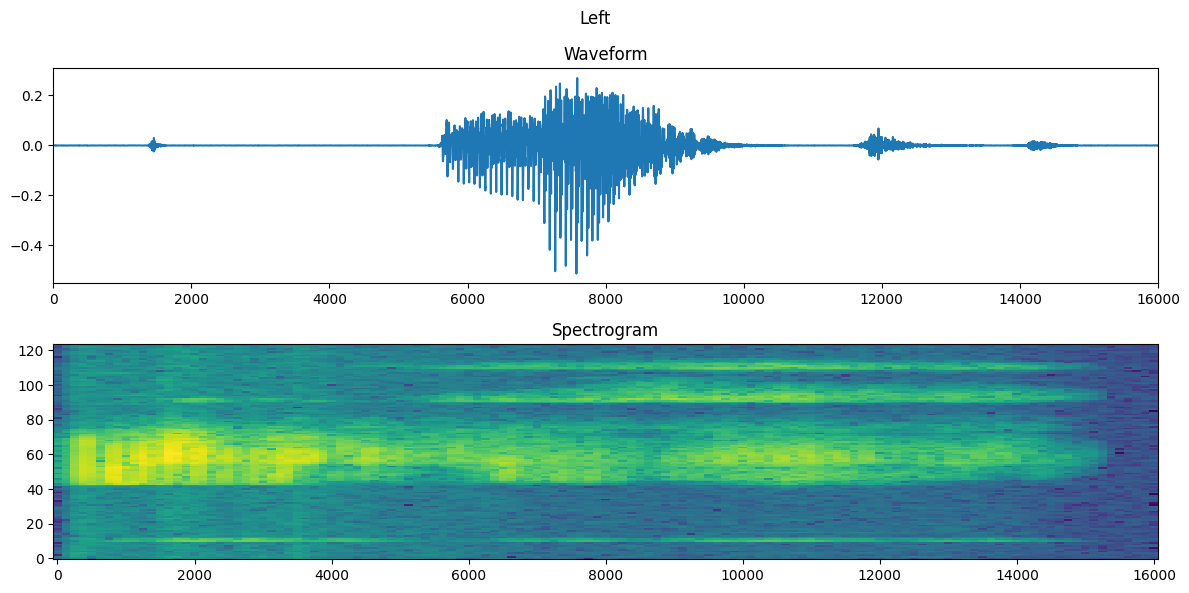

In [ ]:
# Plotting the waveform and spectrogram

fig, axes = plt.subplots(2, figsize=(12, 6))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim(0, 16000)

plot_spectrogram(spectrogram, axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(labels[label].title())
plt.tight_layout()
plt.show()

### 1.5 Create Spectrogram datasets from waveform data

In [ ]:
def make_spec_ds(ds) :
  return ds.map(
      map_func = lambda audio, label : (get_spectrogram(audio), label),
      num_parallel_calls = tf.data.AUTOTUNE
  )

train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

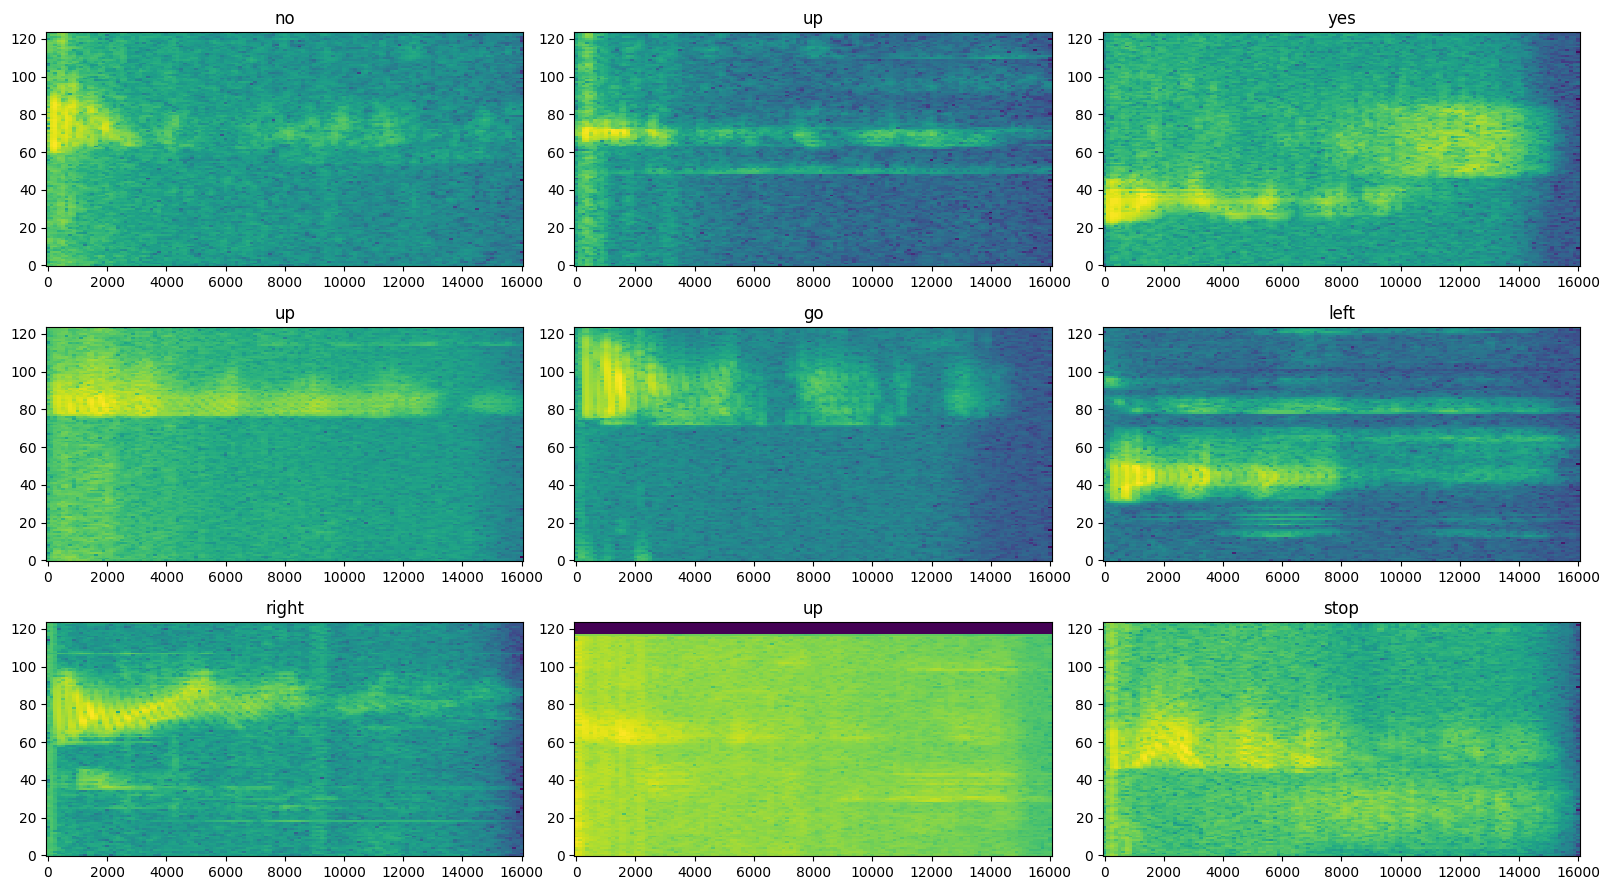

In [ ]:
# Plotting the spectrograms

for sample_spect, sample_spect_labels in train_spectrogram_ds.take(1) :
  break

rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n) :
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(sample_spect[i].numpy(), ax)
  ax.set_title(labels[sample_spect_labels[i].numpy()])

plt.tight_layout()
plt.show()

### 2.1 Build and Train the model

In [ ]:
# Add cache and prefetch to reduce latency

train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
# Building a Convolutional Model as audio data is transformed to spectrogram images

input_shape = sample_spect.shape[1:]
print(f"Input Shape : {input_shape}")
num_labels = len(labels)
print(f"Output Units : {num_labels}")


Input Shape : (124, 129, 1)
Output Units : 8


In [ ]:
# Add a normalization layer

from tensorflow.keras import layers
from tensorflow.keras import models

norm_layer = layers.Normalization()
norm_layer.adapt(data = train_spectrogram_ds.map(
        map_func = lambda spec, label : spec
    ))

model_1 = models.Sequential([
    layers.Input(shape=input_shape),

    # Downsizing the input for faster input
    layers.Resizing(32, 32),

    # Normalize
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0

In [ ]:
# Configuring the model Adam Optimizer and SparseCategoricalCrossentropy

model_1.compile(
    optimizer = tf.keras.optimizers.Adam(),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'],
)

In [ ]:
# Training the model for 10 epochs

EPOCHS = 10

history = model_1.fit(
    train_spectrogram_ds,
    validation_data = val_spectrogram_ds,
    epochs = EPOCHS,
    callbacks = tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/10
100/100 [==============================] - 32s 302ms/step - loss: 1.7671 - accuracy: 0.3494 - val_loss: 1.3619 - val_accuracy: 0.5794
Epoch 2/10
100/100 [==============================] - 36s 363ms/step - loss: 1.2662 - accuracy: 0.5500 - val_loss: 0.9856 - val_accuracy: 0.6953
Epoch 3/10
100/100 [==============================] - 34s 341ms/step - loss: 0.9650 - accuracy: 0.6584 - val_loss: 0.7916 - val_accuracy: 0.7500
Epoch 4/10
100/100 [==============================] - 34s 341ms/step - loss: 0.8163 - accuracy: 0.7127 - val_loss: 0.7430 - val_accuracy: 0.7760
Epoch 5/10
100/100 [==============================] - 25s 246ms/step - loss: 0.6751 - accuracy: 0.7639 - val_loss: 0.6280 - val_accuracy: 0.8268
Epoch 6/10
100/100 [==============================] - 25s 254ms/step - loss: 0.5877 - accuracy: 0.7925 - val_loss: 0.5438 - val_accuracy: 0.8320
Epoch 7/10
100/100 [==============================] - 35s 354ms/step - loss: 0.5302 - accuracy: 0.8127 - val_loss: 0.5298 - val_ac

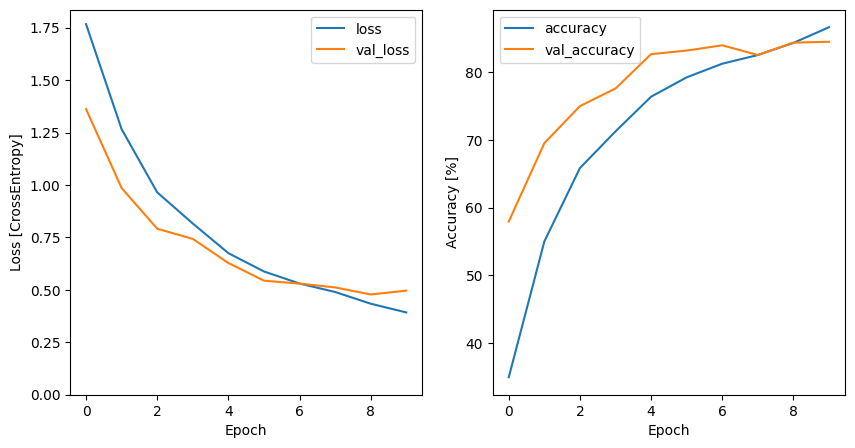

In [ ]:
#Plotting the Loss and Accuracy Curves

metrics = history.history

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.ylim(0, max(plt.ylim()))
plt.legend(['loss', 'val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1, 2, 2)
plt.plot(history.epoch, 100 * np.array(metrics['accuracy']), 100 * np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

plt.show()

### 3.1 Evaluate the model performance

In [ ]:
model_1.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 4s 299ms/step - loss: 0.4780 - accuracy: 0.8450


{'loss': 0.47802355885505676, 'accuracy': 0.8449519276618958}

### 3.2 Display a Confusion Matrix

In [ ]:
y_pred = tf.argmax(model_1.predict(test_spectrogram_ds), axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda spec, label : label)), axis=0)

13/13 [==============================] - 2s 146ms/step


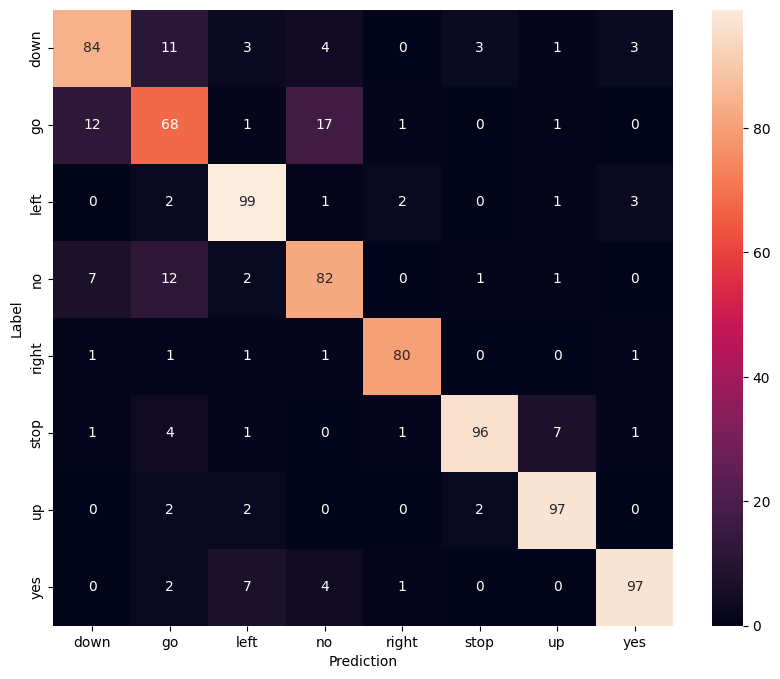

In [ ]:
import seaborn as sns

conf_mat = tf.math.confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat,
            xticklabels=labels,
            yticklabels=labels,
            annot=True,
            fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

### 3.3 Run inference on random audio file

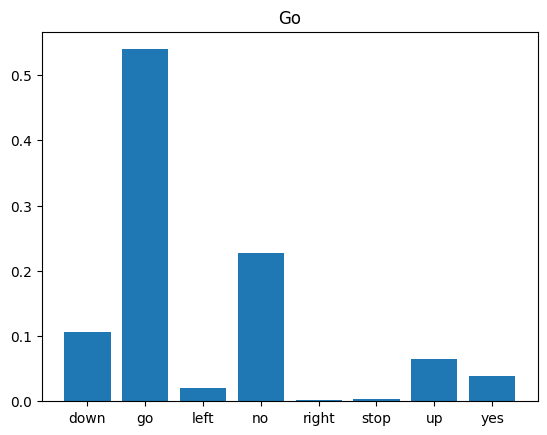

In [ ]:
x = data_dir/'go/004ae714_nohash_0.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis, ...]

pred = model_1(x)
plt.bar(labels, tf.nn.softmax(pred[0]))
plt.title('Go')
plt.show()

display.display(display.Audio(waveform, rate=16000))

### 4. Export the model with preprocessing steps


In [ ]:
class ExportModel(tf.Module) :
  def __init__(self, model) :

    self.model = model
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string),
    )
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32)
    )

  @tf.function
  def __call__(self, x) :
    if x.dtype == tf.string :
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000, )
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, ...]

    x = get_spectrogram(x)
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(labels, class_ids)
    return {
        'predictions' : result,
        'class_ids' : class_ids,
        'class_names' : class_names
    }


In [ ]:
# Test run the export model

export = ExportModel(model_1)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 0.26618177,  1.8289409 , -2.2828317 ,  3.3756535 , -3.076767  ,
         -3.1276343 , -3.2267962 , -2.1911373 ]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'no'], dtype=object)>}

In [ ]:
# Save and reload the model

tf.saved_model.save(export, 'saved')
reloaded_model = tf.saved_model.load('saved')


In [ ]:
print(reloaded_model(waveform[tf.newaxis, :]))

{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'go'], dtype=object)>, 'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[-0.1739378,  1.4449576, -1.8466173,  0.5772317, -4.4771843,
        -3.6048536, -0.6854171, -1.2023048]], dtype=float32)>}
